In [16]:
import math
import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
def getRand(r1, r2, num):
    return (r1 - r2) * torch.rand(num, 1) + r2

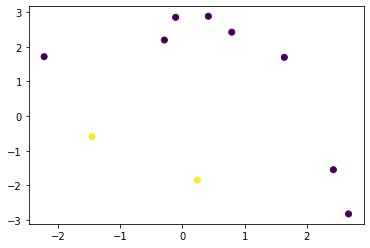

In [18]:
def gen_data(num_data):
    # torch.random.manual_seed(seed)

    # x = torch.rand(num_data,1)
    # y = torch.rand(num_data,1)
    x = getRand(-3, 3, num_data)
    y = getRand(-3, 3, num_data)

    # u = torch.rand(1)
    # data_fn = lambda x, y: torch.sin(x+y)+(x-y)**2-1.5*x+2.5*y+1
    data_fn = lambda x, y: (x**2+y-11)**2+(x+y**2-7)**2
    latent_fn = data_fn(x, y)
    z = latent_fn.long().squeeze()
    # print(z)
    for i in range(len(z)):
        if z[i] > 150:
            z[i] = 1
        else:
            z[i] = 0
    
    # print(latent_fn)
    return torch.cat((x,y),dim=1), z, data_fn

train_x, train_y, genfn = gen_data(10)
plt.scatter(train_x[:,0].numpy(), train_x[:,1].numpy(), c = train_y)

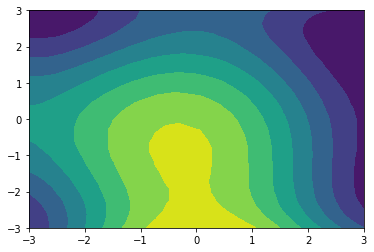

In [19]:
test_d1 = np.linspace(-3, 3, 50)
test_d2 = np.linspace(-3, 3, 50)

test_x_mat, test_y_mat = np.meshgrid(test_d1, test_d2)
test_x_mat, test_y_mat = torch.Tensor(test_x_mat), torch.Tensor(test_y_mat)

test_x = torch.cat((test_x_mat.view(-1,1), test_y_mat.view(-1,1)),dim=1)
test_labels = torch.round(genfn(test_x_mat, test_y_mat))
test_y = test_labels.view(-1)

plt.contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())

In [20]:
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us

likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
model = DirichletGPModel(train_x, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)
print(likelihood.transformed_targets.shape)

torch.Size([2, 10])


In [21]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 100


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, likelihood.transformed_targets).sum()
    loss.backward()
    if (i+1) % 5 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.mean().item(),
            model.likelihood.second_noise_covar.noise.mean().item()
        ))
    optimizer.step()

Iter 5/100 - Loss: 6.045   lengthscale: 0.913   noise: 0.712
Iter 10/100 - Loss: 5.359   lengthscale: 1.239   noise: 0.780
Iter 15/100 - Loss: 4.977   lengthscale: 1.578   noise: 0.874
Iter 20/100 - Loss: 4.745   lengthscale: 1.849   noise: 0.971
Iter 25/100 - Loss: 4.599   lengthscale: 1.994   noise: 1.055
Iter 30/100 - Loss: 4.519   lengthscale: 2.037   noise: 1.122
Iter 35/100 - Loss: 4.463   lengthscale: 2.030   noise: 1.171
Iter 40/100 - Loss: 4.413   lengthscale: 1.996   noise: 1.204
Iter 45/100 - Loss: 4.377   lengthscale: 1.934   noise: 1.221
Iter 50/100 - Loss: 4.345   lengthscale: 1.856   noise: 1.220
Iter 55/100 - Loss: 4.319   lengthscale: 1.776   noise: 1.204
Iter 60/100 - Loss: 4.298   lengthscale: 1.705   noise: 1.173
Iter 65/100 - Loss: 4.281   lengthscale: 1.647   noise: 1.128
Iter 70/100 - Loss: 4.267   lengthscale: 1.603   noise: 1.073
Iter 75/100 - Loss: 4.256   lengthscale: 1.572   noise: 1.011
Iter 80/100 - Loss: 4.247   lengthscale: 1.556   noise: 0.944
Iter 85/1

In [22]:
model.eval()
likelihood.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = model(test_x)

    pred_means = test_dist.loc

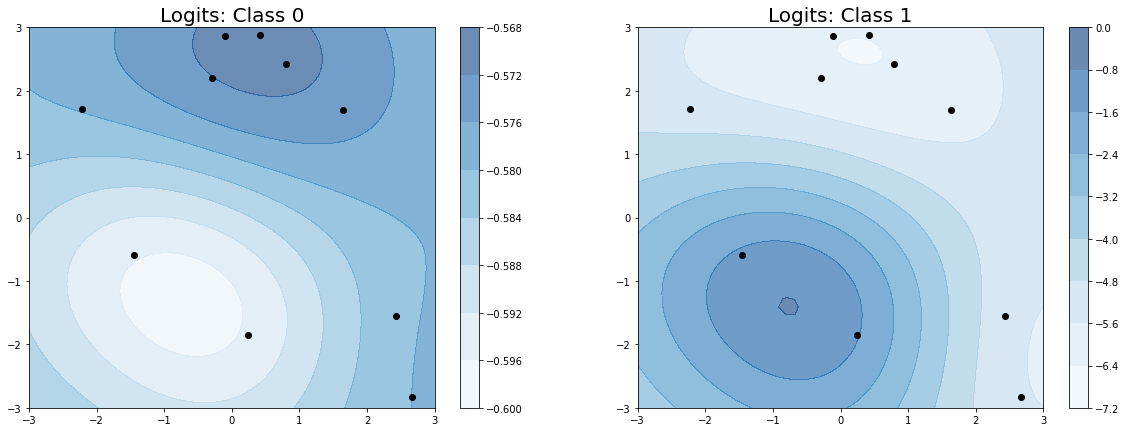

In [23]:
fig, ax = plt.subplots(1, 2, figsize = (20, 7))

for i in range(2):
    im = ax[i].contourf(
        test_x_mat.numpy(), test_y_mat.numpy(), pred_means[i].numpy().reshape((50,50)),
    cmap="Blues", alpha=0.6)
    fig.colorbar(im, ax=ax[i])
    ax[i].plot(train_x[:,0].numpy(), train_x[:,1].numpy(), "ko")
    ax[i].set_title("Logits: Class " + str(i), fontsize = 20)


In [24]:
pred_samples = test_dist.sample(torch.Size((256,))).exp()
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)

I added this below (1/2)

In [25]:
probabilities[0] = probabilities[0]/probabilities[0].max()
probabilities[1] = probabilities[1]/probabilities[1].max()

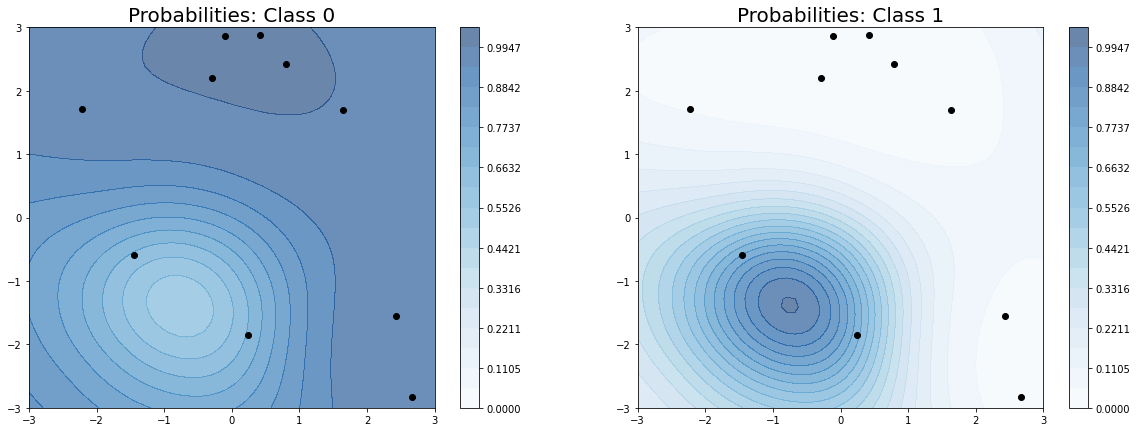

In [26]:
fig, ax = plt.subplots(1, 2, figsize = (20, 7))

levels = np.linspace(0, 1.05, 20)
for i in range(2):
    im = ax[i].contourf(
        test_x_mat.numpy(), test_y_mat.numpy(), probabilities[i].numpy().reshape((50,50)), levels=levels,
    cmap="Blues", alpha=0.6)
    fig.colorbar(im, ax=ax[i])
    ax[i].plot(train_x[:,0].numpy(), train_x[:,1].numpy(), "ko")
    ax[i].set_title("Probabilities: Class " + str(i), fontsize = 20)

And changed below (2/2)

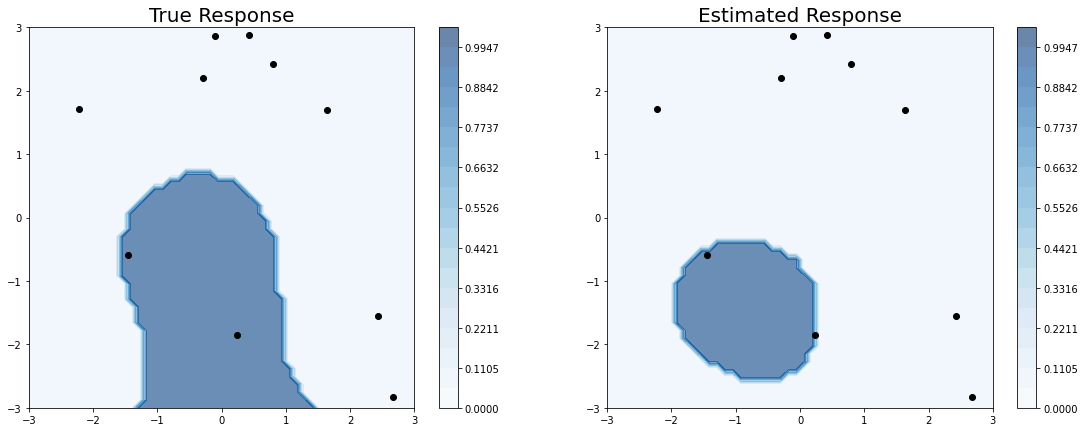

In [27]:
fig, ax = plt.subplots(1,2, figsize=(19, 7))

ax[0].contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels>150, cmap="Blues", alpha=0.6)
ax[0].set_title('True Response', fontsize=20)
ax[0].plot(train_x[:,0].numpy(), train_x[:,1].numpy(), "ko")

fig.colorbar(im, ax=ax[0])
                                                       ######### Right here ########
ax[1].contourf(test_x_mat.numpy(), test_y_mat.numpy(), probabilities.max(0)[1].reshape((50,50)),cmap="Blues", alpha=0.6)
ax[1].set_title('Estimated Response', fontsize=20)
fig.colorbar(im, ax=ax[1])
ax[1].plot(train_x[:,0].numpy(), train_x[:,1].numpy(), "ko")